In [5]:
ls

DataProcessing.py       bregmanbarystab.py      covid_val.npy
OldFiles/               convo.py                freeSupport.py
Results.ipynb           convoCovid.csv          non_test.npy
Results.txt             convoNon.csv            non_train.npy
bregmanbary.py          covid_test.npy          non_val.npy
bregmanbarysinkhorn.py  covid_train.npy         testssh.py


In [6]:
import numpy as np
import math
import ot
import matplotlib.pyplot as plt
from numpy import genfromtxt
# covid barycenter, from convo.py, reg = 0.002
X = genfromtxt('convoCovid.csv', delimiter=',')
# non covid barycenter
Y = genfromtxt('convoNon.csv', delimiter=',')
validation_covid = np.load('covid_val.npy')
validation_non = np.load('non_val.npy')

M = []
k = 50
for i in range(k):
    for j in range(k):
        for m in range(k):
            for n in range(k):
                M.append(math.pow(i-m,2)+math.pow(j-n,2))
M = np.reshape(M, (k*k,k*k))
M = np.array(M)
Xflat = X.flatten()
Xflat /= np.sum(Xflat)
Yflat = Y.flatten()
Yflat /= np.sum(Yflat)

In [35]:
import numpy as np
import ot
a = [0.09,0.2,0.1,0.05,0.05,0.2,0.2, 0.1,0.01]
b = [0.1,0.1,0.1,0.15,0.05,0.1,0.2,0.1,0.1]
a = np.array(a)
b = np.array(b)
k = 3
M = []
for i in range(k):
    for j in range(k):
        for m in range(k):
            for n in range(k):
                M.append(math.pow(i-m,2)+math.pow(j-n,2))
M = np.reshape(M, (k*k,k*k))
M = np.array(M)
dist = ot.bregman.sinkhorn2(a,b,M,reg = 0.002)
dist1 = ot.emd2(a,b,M)
print(M)
print(dist)
print(dist1)

[[0. 1. 4. 1. 2. 5. 4. 5. 8.]
 [1. 0. 1. 2. 1. 2. 5. 4. 5.]
 [4. 1. 0. 5. 2. 1. 8. 5. 4.]
 [1. 2. 5. 0. 1. 4. 1. 2. 5.]
 [2. 1. 2. 1. 0. 1. 2. 1. 2.]
 [5. 2. 1. 4. 1. 0. 5. 2. 1.]
 [4. 5. 8. 1. 2. 5. 0. 1. 4.]
 [5. 4. 5. 2. 1. 2. 1. 0. 1.]
 [8. 5. 4. 5. 2. 1. 4. 1. 0.]]
[0.2941667]
0.3


In [7]:
# analyze result
tp = 0
fp = 0
tn = 0
fn = 0
# calculate wasserstein dist between val image and barycenters
for img in validation_covid:
    mat = img.flatten()
    dist1 = ot.emd2(mat,Xflat,M) 
    dist2 = ot.emd2(mat,Yflat,M)
    #classify correct
    if dist1<dist2:
        tp+=1
    else:
        fn+=1
for img in validation_non:
    mat = img.flatten()
    dist1 = ot.emd2(mat,Xflat,M) 
    dist2 = ot.emd2(mat,Yflat,M)
    #classify correct
    if dist1>dist2:
        tn+=1
    else:
        fp+=1

In [8]:
# Euclidean norm 
normCovid = np.zeros((k,k))
for img in validation_covid:
    normCovid+=img
normCovid /= validation_covid.shape[0]

normNon = np.zeros((k,k))
for img in validation_non:
    normNon += img
normNon /= validation_non.shape[0]
    
# Classification
tpE = 0
fpE = 0
tnE = 0
fnE = 0
# calculate euclidean dist between val image and barycenters
for img in validation_covid:
    mat1 = np.subtract(img, normCovid)
    mat2 = np.subtract(img, normNon)
    dist1 = np.linalg.norm(mat1) 
    dist2 = np.linalg.norm(mat2) 
    #classify correct
    if dist1<dist2:
        tpE +=1
    else:
        fnE +=1
for img in validation_non:
    mat = img.flatten()
    Xflat = X.flatten()
    Yflat = Y.flatten()
    dist1 = ot.emd2(mat,Xflat,M) 
    dist2 = ot.emd2(mat,Yflat,M)
    #classify correct
    if dist1>dist2:
        tnE +=1
    else:
        fpE +=1

In [9]:
print("convolutional2D Result:")
print(tp,fp,tn,fn)
accuracy = (tp+tn)/(tp+tn+fp+fn)*100
recall = tp/(tp+fn)*100
selectivity = tn/(tn+fp)*100
print("Accuracy: % .2f, Recall: % .2f, Selectivity: % .2f" %(accuracy, recall, selectivity))

print("euclidean Result:")
print(tpE,fpE,tnE,fnE)
accuracy = (tpE+tnE)/(tpE+tnE+fpE+fnE)*100
recall = tpE/(tpE+fnE)*100
selectivity = tnE/(tnE+fpE)*100
print("Accuracy: % .2f, Recall: % .2f, Selectivity: % .2f" %(accuracy, recall, selectivity))


convolutional2D Result:
39 30 28 21
Accuracy:  56.78, Recall:  65.00, Selectivity:  48.28
euclidean Result:
45 58 0 15
Accuracy:  38.14, Recall:  75.00, Selectivity:  0.00


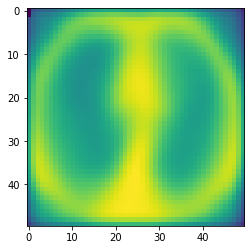

In [4]:
plt.imshow(X)

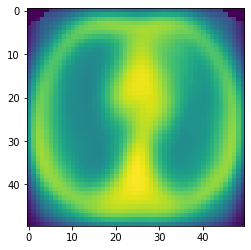

In [5]:
plt.imshow(Y)

In [35]:
import numpy as np
import ot
import matplotlib.pyplot as plt
import math
# Load Data
training_covid = np.load('covid_train.npy')
validation_covid = np.load('covid_val.npy')

training_non = np.load('non_train.npy')
validation_non = np.load('non_val.npy')

# Start training parameters
# A dim*n_his (pixel dist in columns)
N = len(training_covid)
A = []
M = []
for i in range(N):
    arr = training_covid[i].flatten()
    A.append(arr)
A = np.array(A).transpose()

# dimension
k = training_covid.shape[1]
# M dim*dim (euclidean dist)
for i in range(k):
    for j in range(k):
        for m in range(k):
            for n in range(k):
                M.append(math.pow(i-m,2)+math.pow(j-n,2))
M = np.reshape(M, (k*k,k*k))

# A1 dim*n_his (pixel dist in columns)
N1 = len(training_non)
A1 = []
M1 = M
for i in range(N1):
    arr = training_non[i].flatten()
    A1.append(arr)
A1 = np.array(A1).transpose()

# covid
reg = 0.004
examples = len(training_covid)
weights = np.array([1/examples for i in range(examples)]) #weights n*1
X = ot.bregman.barycenter(A, M, reg, weights)


In [36]:
# non-covid
examples1 = len(training_non)
weights1 = np.array([1/examples1 for i in range(examples1)]) #weights1 n*1
Y = ot.bregman.barycenter(A1, M, reg, weights1)

X = np.reshape(X,(k,k))
Y = np.reshape(Y,(k,k))

# np.savetxt("bregmanbaryCovid.csv", X, delimiter=",")
# np.savetxt("bregmanbaryNon.csv", Y, delimiter=",")

# analyze result
tp = 0
fp = 0
tn = 0
fn = 0
# calculate frobenius dist between val image and barycenters
for img in validation_covid:
    mat1 = np.subtract(img,X)
    mat2 = np.subtract(img,Y)
    dist1 = np.linalg.norm(mat1)
    dist2 = np.linalg.norm(mat2)
    # classify correct
    if dist1<dist2:
        tp+=1
    else:
        fn+=1
for img in validation_non:
    mat1 = np.subtract(img,X)
    mat2 = np.subtract(img,Y)
    dist1 = np.linalg.norm(mat1)
    dist2 = np.linalg.norm(mat2)
    # classify correct
    if dist1>dist2:
        tn+=1
    else:
        fp+=1
accuracy = (tp+tn)/(tp+tn+fp+fn)*100
recall = tp/(tp+fn)*100
selectivity = tn/(tn+fp)*100
print("Bregmanbary Result:")
print(tp,fp,tn,fn)
accuracy = (tp+tn)/(tp+tn+fp+fn)*100
recall = tp/(tp+fn)*100
selectivity = tn/(tn+fp)*100
print("Accuracy: % .2f, Recall: % .2f, Selectivity: % .2f" %(accuracy, recall, selectivity))
  


Bregmanbary Result:
0 58 0 60
Accuracy:  0.00, Recall:  0.00, Selectivity:  0.00


In [37]:
import numpy as np
import ot
import matplotlib.pyplot as plt
import math

# Load Data
training_covid = np.load('covid_train.npy')
validation_covid = np.load('covid_val.npy')

training_non = np.load('non_train.npy')
validation_non = np.load('non_val.npy')

# Start training parameters
# A dim*n_his (pixel dist in columns)
N = len(training_covid)
A = []
M = []
for i in range(N):
    arr = training_covid[i].flatten()
    A.append(arr)
A = np.array(A).transpose()

# dimension
k = training_covid.shape[1]
# M dim*dim (euclidean dist)
for i in range(k):
    for j in range(k):
        for m in range(k):
            for n in range(k):
                M.append(math.pow(i-m,2)+math.pow(j-n,2))
M = np.reshape(M, (k*k,k*k))

# A1 dim*n_his (pixel dist in columns)
N1 = len(training_non)
A1 = []
M1 = M
for i in range(N1):
    arr = training_non[i].flatten()
    A1.append(arr)
A1 = np.array(A1).transpose()

# covid
reg = 0.002
examples = len(training_covid)
weights = np.array([1/examples for i in range(examples)]) #weights n*1
X = ot.bregman.barycenter_sinkhorn(A, M, reg, weights)

# non-covid
examples1 = len(training_non)
weights1 = np.array([1/examples1 for i in range(examples1)]) #weights1 n*1
Y = ot.bregman.barycenter_sinkhorn(A1, M, reg, weights1)

X = np.reshape(X,(k,k))
Y = np.reshape(Y,(k,k))

np.savetxt("bregmanbarysinkhornCovid.csv", X, delimiter=",")
np.savetxt("bregmanbarysinkhornNon.csv", Y, delimiter=",")


# analyze result
tp = 0
fp = 0
tn = 0
fn = 0
# calculate frobenius dist between val image and barycenters
for img in validation_covid:
    mat1 = np.subtract(img,X)
    mat2 = np.subtract(img,Y)
    dist1 = np.linalg.norm(mat1)
    dist2 = np.linalg.norm(mat2)
    # classify correct
    if dist1<dist2:
        tp+=1
    else:
        fn+=1
for img in validation_non:
    mat1 = np.subtract(img,X)
    mat2 = np.subtract(img,Y)
    dist1 = np.linalg.norm(mat1)
    dist2 = np.linalg.norm(mat2)
    # classify correct
    if dist1>dist2:
        tn+=1
    else:
        fp+=1
accuracy = (tp+tn)/(tp+tn+fp+fn)*100
recall = tp/(tp+fn)*100
selectivity = tn/(tn+fp)*100
print("Breg Sinkhorn Result:")
print(tp,fp,tn,fn)
accuracy = (tp+tn)/(tp+tn+fp+fn)*100
recall = tp/(tp+fn)*100
selectivity = tn/(tn+fp)*100
print("Accuracy: % .2f, Recall: % .2f, Selectivity: % .2f" %(accuracy, recall, selectivity))

Breg Sinkhorn Result:
0 58 0 60
Accuracy:  0.00, Recall:  0.00, Selectivity:  0.00
